In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import alphalens as al
import scipy.stats as ss
from scipy.optimize import minimize
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
from tqdm import tqdm
style.use('ggplot')
style.use('seaborn-poster')

import pandas_datareader.data as web
import pandas_datareader as pdr
import numpy as np

In [11]:
df = pdr.get_data_tiingo('GOOG', api_key=os.getenv('TIINGO_API_KEY')).droplevel(0)
#df.columns = df.columns.droplevel(1)
df['adjClose'].head()

date
2014-03-27 00:00:00+00:00    558.46
2014-03-28 00:00:00+00:00    559.99
2014-03-31 00:00:00+00:00    556.97
2014-04-01 00:00:00+00:00    567.16
2014-04-02 00:00:00+00:00    567.00
Name: adjClose, dtype: float64

In [1247]:
start = dt.datetime(2019, 3, 1)
end = dt.datetime(2019, 11, 30)
tickers = ['UPRO', 'TLT', 'GLD', 'VXX']
df = pd.DataFrame()
for ticker in tickers:
    tmp = pdr.get_data_tiingo(ticker, api_key=os.getenv('TIINGO_API_KEY')).droplevel(0).loc[start:,:]
    tmp = tmp['adjClose']
    tmp.name = ticker
    df = pd.concat([df, tmp], axis=1)
    df = df.loc[:end].copy()

df.head()

,UPRO,TLT,GLD,VXX
2019-03-01 00:00:00+00:00,47.857546,117.240408,121.88,29.98
2019-03-04 00:00:00+00:00,47.289592,118.159282,121.56,30.71
2019-03-05 00:00:00+00:00,47.090310,118.406291,121.72,30.89
2019-03-06 00:00:00+00:00,46.223434,118.841027,121.61,31.80
2019-03-07 00:00:00+00:00,45.067599,119.611696,121.51,33.01


In [1248]:
rets = df.pct_change()
rets.tail()

,UPRO,TLT,GLD,VXX
2019-09-03 00:00:00+00:00,-0.017162,0.001291,0.013913,0.044074
2019-09-04 00:00:00+00:00,0.032790,0.001494,0.006244,-0.061724
2019-09-05 00:00:00+00:00,0.039264,-0.018110,-0.024001,-0.037051
2019-09-06 00:00:00+00:00,0.002169,0.007115,-0.008383,-0.029446
2019-09-09 00:00:00+00:00,0.001082,-0.017765,-0.003875,-0.009709


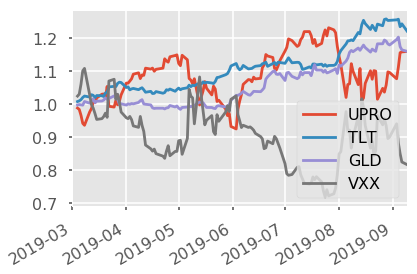

In [1249]:
(1+rets).cumprod().plot()

In [1255]:
np.random.seed(101)

num_ports = 5000
all_weights = pd.DataFrame(np.zeros((num_ports, len(rets.columns))), columns=tickers)
ret_arr = np.zeros(num_ports)
std_arr = np.zeros(num_ports)
sr_arr = np.zeros(num_ports)

for ix in range(num_ports):
    weights = np.random.random(len(rets.columns))
    reb_weights = weights / np.sum(weights)
    #reb_weights = reb_weights * 0.60
    #reb_weights = np.append([0.40], reb_weights)
    reb_weights = np.array([0.30, 0.30, 0.30, 0.10])
    all_weights.loc[ix,:] = reb_weights
    
    ret_arr[ix] = np.sum((rets.mean() * reb_weights) * 252)
    std_arr[ix] = np.sqrt(np.dot(reb_weights.T, np.dot(rets.cov() * 252, reb_weights)))
    sr_arr[ix] = ret_arr[ix]/std_arr[ix]

In [1256]:
print('max sharpe: ', sr_arr.max())
max_sharpe_ix = sr_arr.argmax()
max_sr_ret = ret_arr[max_sharpe_ix]
max_sr_std = std_arr[max_sharpe_ix]

max sharpe:  3.879857360096308


In [1257]:

all_weights.loc[max_sharpe_ix,:]

UPRO    0.3
TLT     0.3
GLD     0.3
VXX     0.1
Name: 0, dtype: float64

In [1258]:
(rets.mean()*252 * all_weights.loc[max_sharpe_ix,:]).sum()

0.2981080776786306

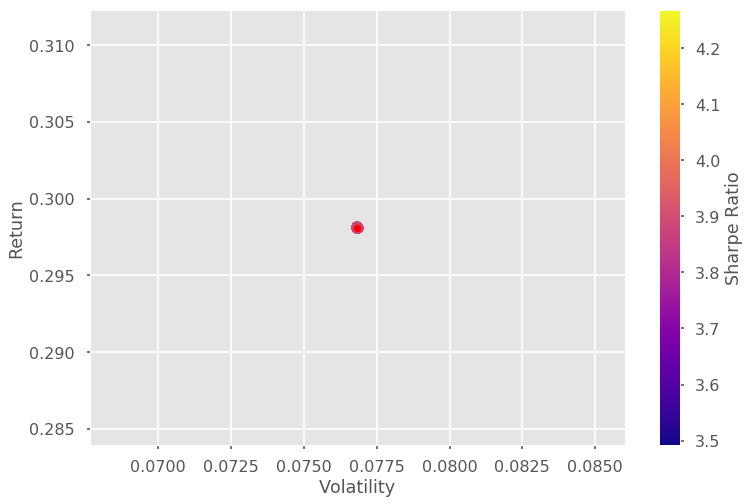

In [1259]:
plt.figure(figsize=(12,8))
plt.scatter(std_arr, ret_arr, c=sr_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_std, max_sr_ret, c='red', s=50)

# Adding the Efficient Frontier

In [213]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(rets.mean()*weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(rets.cov()*252, weights)))
    sr = ret / std
    return np.array([ret, std, sr])

In [214]:
# our function to minimize:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [215]:
def check_sum(weights):
    # return 0 if sum of weights is 1
    return np.sum(weights) - 1

In [216]:
cons = ({'type': 'eq', 'fun': check_sum}) # should return 0 for correct constraint

In [217]:
num_assets = len(df.columns)
bounds = [(0,1) for i in range(num_assets)]
print(bounds)
init_guess = [1/num_assets] * len(df.columns)
print(init_guess)

[(0, 1), (0, 1), (0, 1), (0, 1)]
[0.25, 0.25, 0.25, 0.25]


In [218]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons,
                      options={'maxiter': 2000})
opt_results

     fun: -6.135306636849946
     jac: array([-0.00956964,  0.00284219,  0.00218159, -0.00089777])
 message: 'Optimization terminated successfully.'
    nfev: 54
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.08215282, 0.30088974, 0.15724218, 0.45971527])

In [219]:
get_ret_vol_sr(init_guess)

array([0.31590647, 0.0874205 , 3.61364291])

In [220]:
get_ret_vol_sr(opt_results.x)

array([0.40831007, 0.06655088, 6.13530664])

In [221]:
frontier_y = np.linspace(0, 0.45, 100)

In [222]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [223]:
frontier_vol = []

for pos_ret in tqdm(frontier_y):
    cons = ({'type':'eq', 'fun': check_sum}, {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - pos_ret})
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons,
                      options={'maxiter': 2000})
    frontier_vol.append(result['fun'])



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:11,  8.87it/s]

  2%|▏         | 2/100 [00:00<00:10,  8.97it/s]

  3%|▎         | 3/100 [00:00<00:10,  9.05it/s]

  4%|▍         | 4/100 [00:00<00:10,  9.08it/s]

  5%|▌         | 5/100 [00:00<00:10,  9.10it/s]

  6%|▌         | 6/100 [00:00<00:10,  9.11it/s]

  7%|▋         | 7/100 [00:00<00:10,  9.05it/s]

  8%|▊         | 8/100 [00:00<00:10,  9.15it/s]

  9%|▉         | 9/100 [00:00<00:09,  9.15it/s]

 10%|█         | 10/100 [00:01<00:09,  9.19it/s]

 11%|█         | 11/100 [00:01<00:09,  9.18it/s]

 12%|█▏        | 12/100 [00:01<00:09,  9.09it/s]

 13%|█▎        | 13/100 [00:01<00:09,  8.86it/s]

 14%|█▍        | 14/100 [00:01<00:09,  8.83it/s]

 15%|█▌        | 15/100 [00:01<00:09,  8.84it/s]

 16%|█▌        | 16/100 [00:01<00:09,  8.93it/s]

 17%|█▋        | 17/100 [00:01<00:09,  8.94it/s]

 18%|█▊        | 18/100 [00:01<00:09,  8.98it/s]

 19%|█▉        | 19/100 [00:02<00:09,  8.98it/s]

 20%|██        |

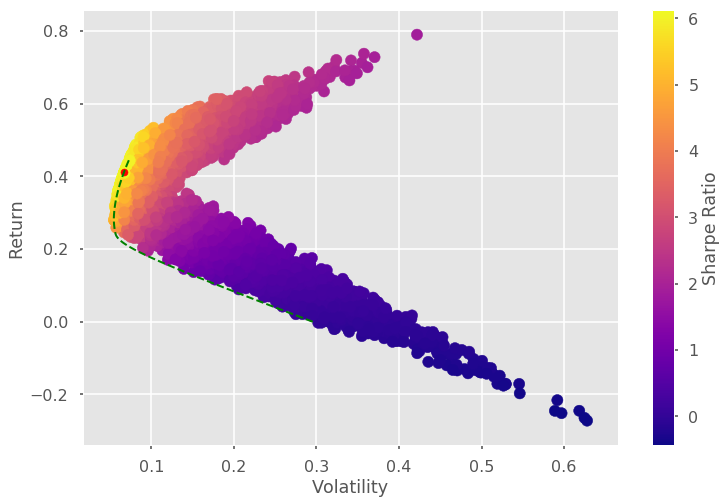

In [224]:
plt.figure(figsize=(12,8))
plt.scatter(std_arr, ret_arr, c=sr_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_std, max_sr_ret, c='red', s=50)

plt.plot(frontier_vol, frontier_y, 'g--', lw=2)

In [225]:
frontier_vol

[0.2956225987218579,
 0.2903652223315799,
 0.2851115976152606,
 0.2798619358792657,
 0.27461646442280035,
 0.26937542795854486,
 0.2641390904968057,
 0.25890773725581373,
 0.25368167642590866,
 0.2484612420850883,
 0.2432467964525679,
 0.23803873303089623,
 0.23283748024433976,
 0.22764350473939673,
 0.2224573162646005,
 0.2172794727464833,
 0.21211058474495542,
 0.20695132394052354,
 0.20180242832197828,
 0.19666471161789603,
 0.19153907429581044,
 0.1864265121410431,
 0.18132813122967045,
 0.17624516226156642,
 0.1711789781636694,
 0.16613111459745727,
 0.16110329342329657,
 0.1560974520589993,
 0.1511157730321006,
 0.1461607295108362,
 0.1412351230743007,
 0.13634214418578652,
 0.1314854368787568,
 0.12666917190549395,
 0.12189814392519051,
 0.11717787814634113,
 0.11251476375855762,
 0.10791620959468422,
 0.1033908304745336,
 0.09894866677466917,
 0.09460144178485938,
 0.09036285862224425,
 0.08624893590715926,
 0.08227837488359256,
 0.07847293993162525,
 0.0748578180698235,
 0.071